In [1]:
import pickle
import sympy as sp
import numpy as np

from IPython.display import display
from IPython.display import HTML

from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

import matplotlib.pyplot as plt
import matplotlib.animation as ani
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

from plot_utils import *

In [2]:
# SYSTEM CONSTANTS
g = sp.symbols("g")
l1, l2 = sp.symbols(["l1", "l2"])
m1, m2 = sp.symbols(["m1", "m2"])
# SYSTEM STATES
psi1, phi2 = sp.symbols(["\\psi_1", "\\phi_2"])
dpsi1, dphi2 = sp.symbols(["\\dot{\\psi_1}", "\\dot{\\phi_2}"])
ddpsi1, ddphi2 = sp.symbols(["\\ddot{\\psi_1}", "\\ddot{\\phi_2}"])
tau = sp.symbols("\\tau") # force input

In [3]:
q = sp.Matrix([psi1, phi2])
dq = sp.Matrix([dpsi1, dphi2])
ddq = sp.Matrix([ddpsi1, ddphi2])

In [4]:
def rot_x(x):
    c = sp.cos(x)
    s = sp.sin(x)
    return sp.Matrix([
        [1, 0, 0],
        [0, c, s],
        [0, -s, c]
    ])

def rot_y(y):
    c = sp.cos(y)
    s = sp.sin(y)
    return sp.Matrix([
        [c, 0, -s],
        [0, 1, 0],
        [s, 0, c]
    ])

def rot_z(z):
    c = sp.cos(z)
    s = sp.sin(z)
    return sp.Matrix([
        [c, s, 0],
        [-s, c, 0],
        [0, 0, 1]
    ])

In [5]:
RI_1 = rot_z(psi1)
R1_I = RI_1.T

RI_2 = rot_x(phi2) @ RI_1
R2_I = RI_2.T

[x1, y1, z1] = R1_I @ sp.Matrix([l1, 0, 0])
[x2, y2, z2] = sp.Matrix([x1, y1, z1]) + R2_I @ sp.Matrix([0, 0, -l2])

In [6]:
# calculate derivatives
p1 = sp.Matrix([x1, y1, z1, psi1])
[dx1, dy1, dz1, dpsi1] = p1.jacobian(q)*dq
p2 = sp.Matrix([x2, y2, z2, phi2])
[dx2, dy2, dz2, dphi2] = p2.jacobian(q)*dq

# kinetic energy
T = sp.Matrix([0.5*m1*(dx1**2 + dy1**2 + dz1**2) + 0.5*m2*(dx2**2 + dy2**2 + dz2**2)])
# potential energy
V = sp.Matrix([m1*g*z1 + m2*g*z2])

#formulate the Lagrangian
L = T-V

# Euler-Lagrange equations
lg1 = sp.zeros(1,len(q))
for i in range(len(q)):
    dL_ddq = sp.diff(L, dq[i])
    lg1[i] = dL_ddq.jacobian(q)*dq + dL_ddq.jacobian(dq)*ddq

lg2 = L.jacobian(q)

# forces
F = sp.Matrix([0, 0, 0, tau])
r = sp.Matrix([0, 0, 0, psi1])
J = r.jacobian(q)
Q = J.transpose()*F

eom = lg1 - lg2 - Q.transpose()

In [7]:
eom

Matrix([[0.5*\ddot{\phi_2}*m2*(-l2*(-2*l1*sin(\psi_1) - 2*l2*sin(\phi_2)*cos(\psi_1))*sin(\psi_1)*cos(\phi_2) + l2*(2*l1*cos(\psi_1) - 2*l2*sin(\phi_2)*sin(\psi_1))*cos(\phi_2)*cos(\psi_1)) + \ddot{\psi_1}*(0.5*m1*(2*l1**2*sin(\psi_1)**2 + 2*l1**2*cos(\psi_1)**2) + 0.5*m2*((-2*l1*sin(\psi_1) - 2*l2*sin(\phi_2)*cos(\psi_1))*(-l1*sin(\psi_1) - l2*sin(\phi_2)*cos(\psi_1)) + (l1*cos(\psi_1) - l2*sin(\phi_2)*sin(\psi_1))*(2*l1*cos(\psi_1) - 2*l2*sin(\phi_2)*sin(\psi_1)))) + 0.5*\dot{\phi_2}*m2*(-2*l2*(-\dot{\phi_2}*l2*sin(\psi_1)*cos(\phi_2) + \dot{\psi_1}*(-l1*sin(\psi_1) - l2*sin(\phi_2)*cos(\psi_1)))*cos(\phi_2)*cos(\psi_1) - 2*l2*(\dot{\phi_2}*l2*cos(\phi_2)*cos(\psi_1) + \dot{\psi_1}*(l1*cos(\psi_1) - l2*sin(\phi_2)*sin(\psi_1)))*sin(\psi_1)*cos(\phi_2) + (-2*l1*sin(\psi_1) - 2*l2*sin(\phi_2)*cos(\psi_1))*(\dot{\phi_2}*l2*sin(\phi_2)*sin(\psi_1) - \dot{\psi_1}*l2*cos(\phi_2)*cos(\psi_1)) + (2*l1*cos(\psi_1) - 2*l2*sin(\phi_2)*sin(\psi_1))*(-\dot{\phi_2}*l2*sin(\phi_2)*cos(\psi_1) - \do

In [8]:
l1_val = 1
l2_val = 1
m1_val = 1
m2_val = 1

h = 0.02
N = 400

In [9]:
m = ConcreteModel(name = "Pendulum from measurements")


# SETS
m.N = RangeSet(N) #number of points in trajectory
m.L = RangeSet(2) #number of links
m.N_meas = RangeSet(6) #number of measured params (x1, y1, z1, x2, y2, z2)



# PARAMETERS
m.g = Param(initialize=9.81) #gravity
m.h = Param(initialize=0.02) #timestep
m.m = Param(m.L, initialize=1.0) #mass of links
m.len = Param(m.L, initialize = 1.0) #length of links



# VARIABLES
m.th = Var(m.N, m.L, within=Reals) #position
m.dth = Var(m.N, m.L, within=Reals) #velocity
m.ddth = Var(m.N, m.L, within=Reals) #acceleration
m.Tc = Var(m.N, within=Reals) #torque
m.slack = Var(within=Reals)



# INTEGRATION CONSTRAINTS
def backwards_euler_pos(m,n,l): # for positions
    if n > 1:
        return m.th[n,l] == m.th[n-1,l] + m.h*m.dth[n,l]
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to (i.e. the first point)
m.integrate_p = Constraint(m.N, m.L, rule = backwards_euler_pos)

def backwards_euler_vel(m,n,l): # for velocities
    if n > 1:
        return m.dth[n,l] == m.dth[n-1,l] + m.h*m.ddth[n,l]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.L, rule = backwards_euler_vel)



# EOM CONSTRAINTS

# lambdify the EOM
func_map = {'sin':sin, 'cos':cos} 
sym_list = [g, psi1, phi2, dpsi1, dphi2, ddpsi1, ddphi2, tau, m1, m2, l1, l2] # list of the symbols that will be substituted with inputs
lamb_eom_1 = sp.lambdify(sym_list, eom[0], modules=[func_map])
lamb_eom_2 = sp.lambdify(sym_list, eom[1], modules=[func_map])

def eom1(m,n):
    var_list = [m.g, m.th[n,1], m.th[n,2], m.dth[n,1], m.dth[n,2], m.ddth[n,1], m.ddth[n,2], m.Tc[n], m.m[1], m.m[2], m.len[1], m.len[2]] 
    return lamb_eom_1(*var_list) == 0
m.eom1 = Constraint(m.N, rule=eom1)

def eom2(m,n):
    var_list = [m.g, m.th[n,1], m.th[n,2], m.dth[n,1], m.dth[n,2], m.ddth[n,1], m.ddth[n,2], m.Tc[n], m.m[1], m.m[2], m.len[1], m.len[2]] 
    return lamb_eom_2(*var_list) == 0
m.eom2 = Constraint(m.N, rule=eom2)



# OBJECTIVE FUNCTION
def obj(m):
    torque_sum = 0
    for n in range(1,N+1):
            torque_sum += m.Tc[n]**2
    return torque_sum
m.obj = Objective(rule = obj)


# INITIALISATION
for n in range(1,N+1):
    m.Tc[n].value = 0
    
    for l in range(1,3):
        m.th[n,l].value = n/N * np.random.uniform(-np.pi, np.pi)
        m.dth[n,l].value = 0
        m.ddth[n,l].value = 0
        
        
# Boundary conditions
# you should to do these after initialization so the values you want to be fixed don't accidentally end up being changed

# initial condition
m.th[1,1].fixed = True # if a variable's value is fixed, the solver treats it like a parameter
m.th[1,1].value = 0
m.th[1,2].fixed = True
m.th[1,2].value = 0

m.dth[1,1].fixed = True 
m.dth[1,1].value = 0
m.dth[1,2].fixed = True
m.dth[1,2].value = 0

# final condition
m.th[N,1].fixed = True
m.th[N,1].value = 0
m.th[N,2].fixed = True
m.th[N,2].value = np.pi

m.dth[N,1].fixed = True 
m.dth[N,1].value = 0
m.dth[N,2].fixed = True
m.dth[N,2].value = 0

In [10]:
# solving
opt = SolverFactory('ipopt')

# solver options
opt.options["print_level"] = 5
opt.options["max_iter"] = 30000
opt.options["max_cpu_time"] = 300
opt.options["acceptable_tol"] = 1e-6
opt.options["tol"] = 1e-12

results = opt.solve(m, tee = False)

# For debugging:
print(results.solver.status)
print(results.solver.termination_condition)

ok
optimal


In [11]:
sym_list_meas = [psi1, phi2, l1, l2]
lamb_x1 = sp.lambdify(sym_list_meas, x1, modules=[func_map])
lamb_y1 = sp.lambdify(sym_list_meas, y1, modules=[func_map])
lamb_z1 = sp.lambdify(sym_list_meas, z1, modules=[func_map])
lamb_x2 = sp.lambdify(sym_list_meas, x2, modules=[func_map])
lamb_y2 = sp.lambdify(sym_list_meas, y2, modules=[func_map])
lamb_z2 = sp.lambdify(sym_list_meas, z2, modules=[func_map])

def plot_rotary_pendulum(psi1_val, phi2_val, l1_val, l2_val):
    fig = plt.figure(figsize=(5,5))
    ax = plt.gca(projection='3d')
    x = [0, lamb_x1(psi1_val, phi2_val, l1_val, l2_val), lamb_x2(psi1_val, phi2_val, l1_val, l2_val)]
    y = [0, lamb_y1(psi1_val, phi2_val, l1_val, l2_val), lamb_y2(psi1_val, phi2_val, l1_val, l2_val)]
    z = [0, lamb_z1(psi1_val, phi2_val, l1_val, l2_val), lamb_z2(psi1_val, phi2_val, l1_val, l2_val)]
    ax.set_xlim((-5, 5))
    ax.set_ylim((-5, 5))
    ax.set_zlim((-5, 5))
    ax.plot(x,y,z)
    ax.plot(x, y, z, '.r', markersize=10)

In [12]:
def np_rot_x(x):
    c = np.cos(x)
    s = np.sin(x)
    return np.array([
        [1, 0, 0],
        [0, c, s],
        [0, -s, c]
    ])

def np_rot_y(y):
    c = np.cos(y)
    s = np.sin(y)
    return np.array([
        [c, 0, -s],
        [0, 1, 0],
        [s, 0, c]
    ])

def np_rot_z(z):
    c = np.cos(z)
    s = np.sin(z)
    return np.array([
        [c, s, 0],
        [-s, c, 0],
        [0, 0, 1]
    ])

In [13]:
RI = np.eye(3)
tI = np.array([[0,0,0]]).T

R1 = np_rot_x(-np.pi/2)@np_rot_z(0)
t1 = np.array([[0,0,4]]).T

R2 = np_rot_x(-np.pi/2)@np_rot_z(np.pi/2)
t2 = np.array([[0,0,4]]).T

K = np.array([
    [1000,0,500],
    [0,1000,500],
    [0,0,1],
])

K_arr = np.array([K, K])
R_arr = np.array([R1, R2])
t_arr = np.array([t1, t2])

In [14]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca(projection='3d')

def plot_pendulum(i, m, ax):
    ax.clear()
    ax.set_xlim((-3, 3))
    ax.set_ylim((-3, 3))
    ax.set_zlim((-3, 3))
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    
    psi1_val = m.th[i, 1].value
    phi2_val = m.th[i, 2].value
    l1_val = m.len[1]
    l2_val = m.len[2]
    
    x = [0, lamb_x1(psi1_val, phi2_val, l1_val, l2_val), lamb_x2(psi1_val, phi2_val, l1_val, l2_val)]
    y = [0, lamb_y1(psi1_val, phi2_val, l1_val, l2_val), lamb_y2(psi1_val, phi2_val, l1_val, l2_val)]
    z = [0, lamb_z1(psi1_val, phi2_val, l1_val, l2_val), lamb_z2(psi1_val, phi2_val, l1_val, l2_val)]

    plot_camera_axis(ax, RI, tI)
    plot_camera_axis(ax, R1, t1)
    plot_camera_axis(ax, R2, t2)
    ax.plot(x,y,z, linewidth=3, zorder=2)
    ax.plot(x, y, z, '.k', markersize=20, zorder=3)

    
update = lambda i: plot_pendulum(i, m, ax)
animate = ani.FuncAnimation(fig, update, range(1, N+1), interval = m.h*1000, repeat=True)
plt.close('all')
HTML(animate.to_html5_video())

In [15]:
fig, axs = plt.subplots(1,2, figsize=(12, 6), sharex=True)
def plot_pendulum(i, m, axs):
    psi1_val = m.th[i, 1].value
    phi2_val = m.th[i, 2].value
    l1_val = m.len[1]
    l2_val = m.len[2]
    
    x = [0, lamb_x1(psi1_val, phi2_val, l1_val, l2_val), lamb_x2(psi1_val, phi2_val, l1_val, l2_val)]
    y = [0, lamb_y1(psi1_val, phi2_val, l1_val, l2_val), lamb_y2(psi1_val, phi2_val, l1_val, l2_val)]
    z = [0, lamb_z1(psi1_val, phi2_val, l1_val, l2_val), lamb_z2(psi1_val, phi2_val, l1_val, l2_val)]
    
    pts = np.vstack([x,y,z]).T.reshape((-1,3,1))
    
    for i, (k, r, t) in enumerate(zip(K_arr, R_arr, t_arr)):
        pts_2d = project(pts, k, r, t)
        axs[i].clear()
        axs[i].set_xlim((0, 1000))
        axs[i].set_ylim((1000, 0))
        axs[i].set_xlabel("X")
        axs[i].set_ylabel("Y")
        axs[i].plot(pts_2d[:,0],pts_2d[:,1], linewidth=3)
        axs[i].plot(pts_2d[:,0],pts_2d[:,1], '.k', markersize=20)
 
    
update = lambda i: plot_pendulum(i, m, axs)
animate = ani.FuncAnimation(fig, update, range(1, N+1), interval = m.h*1000, repeat=True)
plt.close('all')
HTML(animate.to_html5_video())

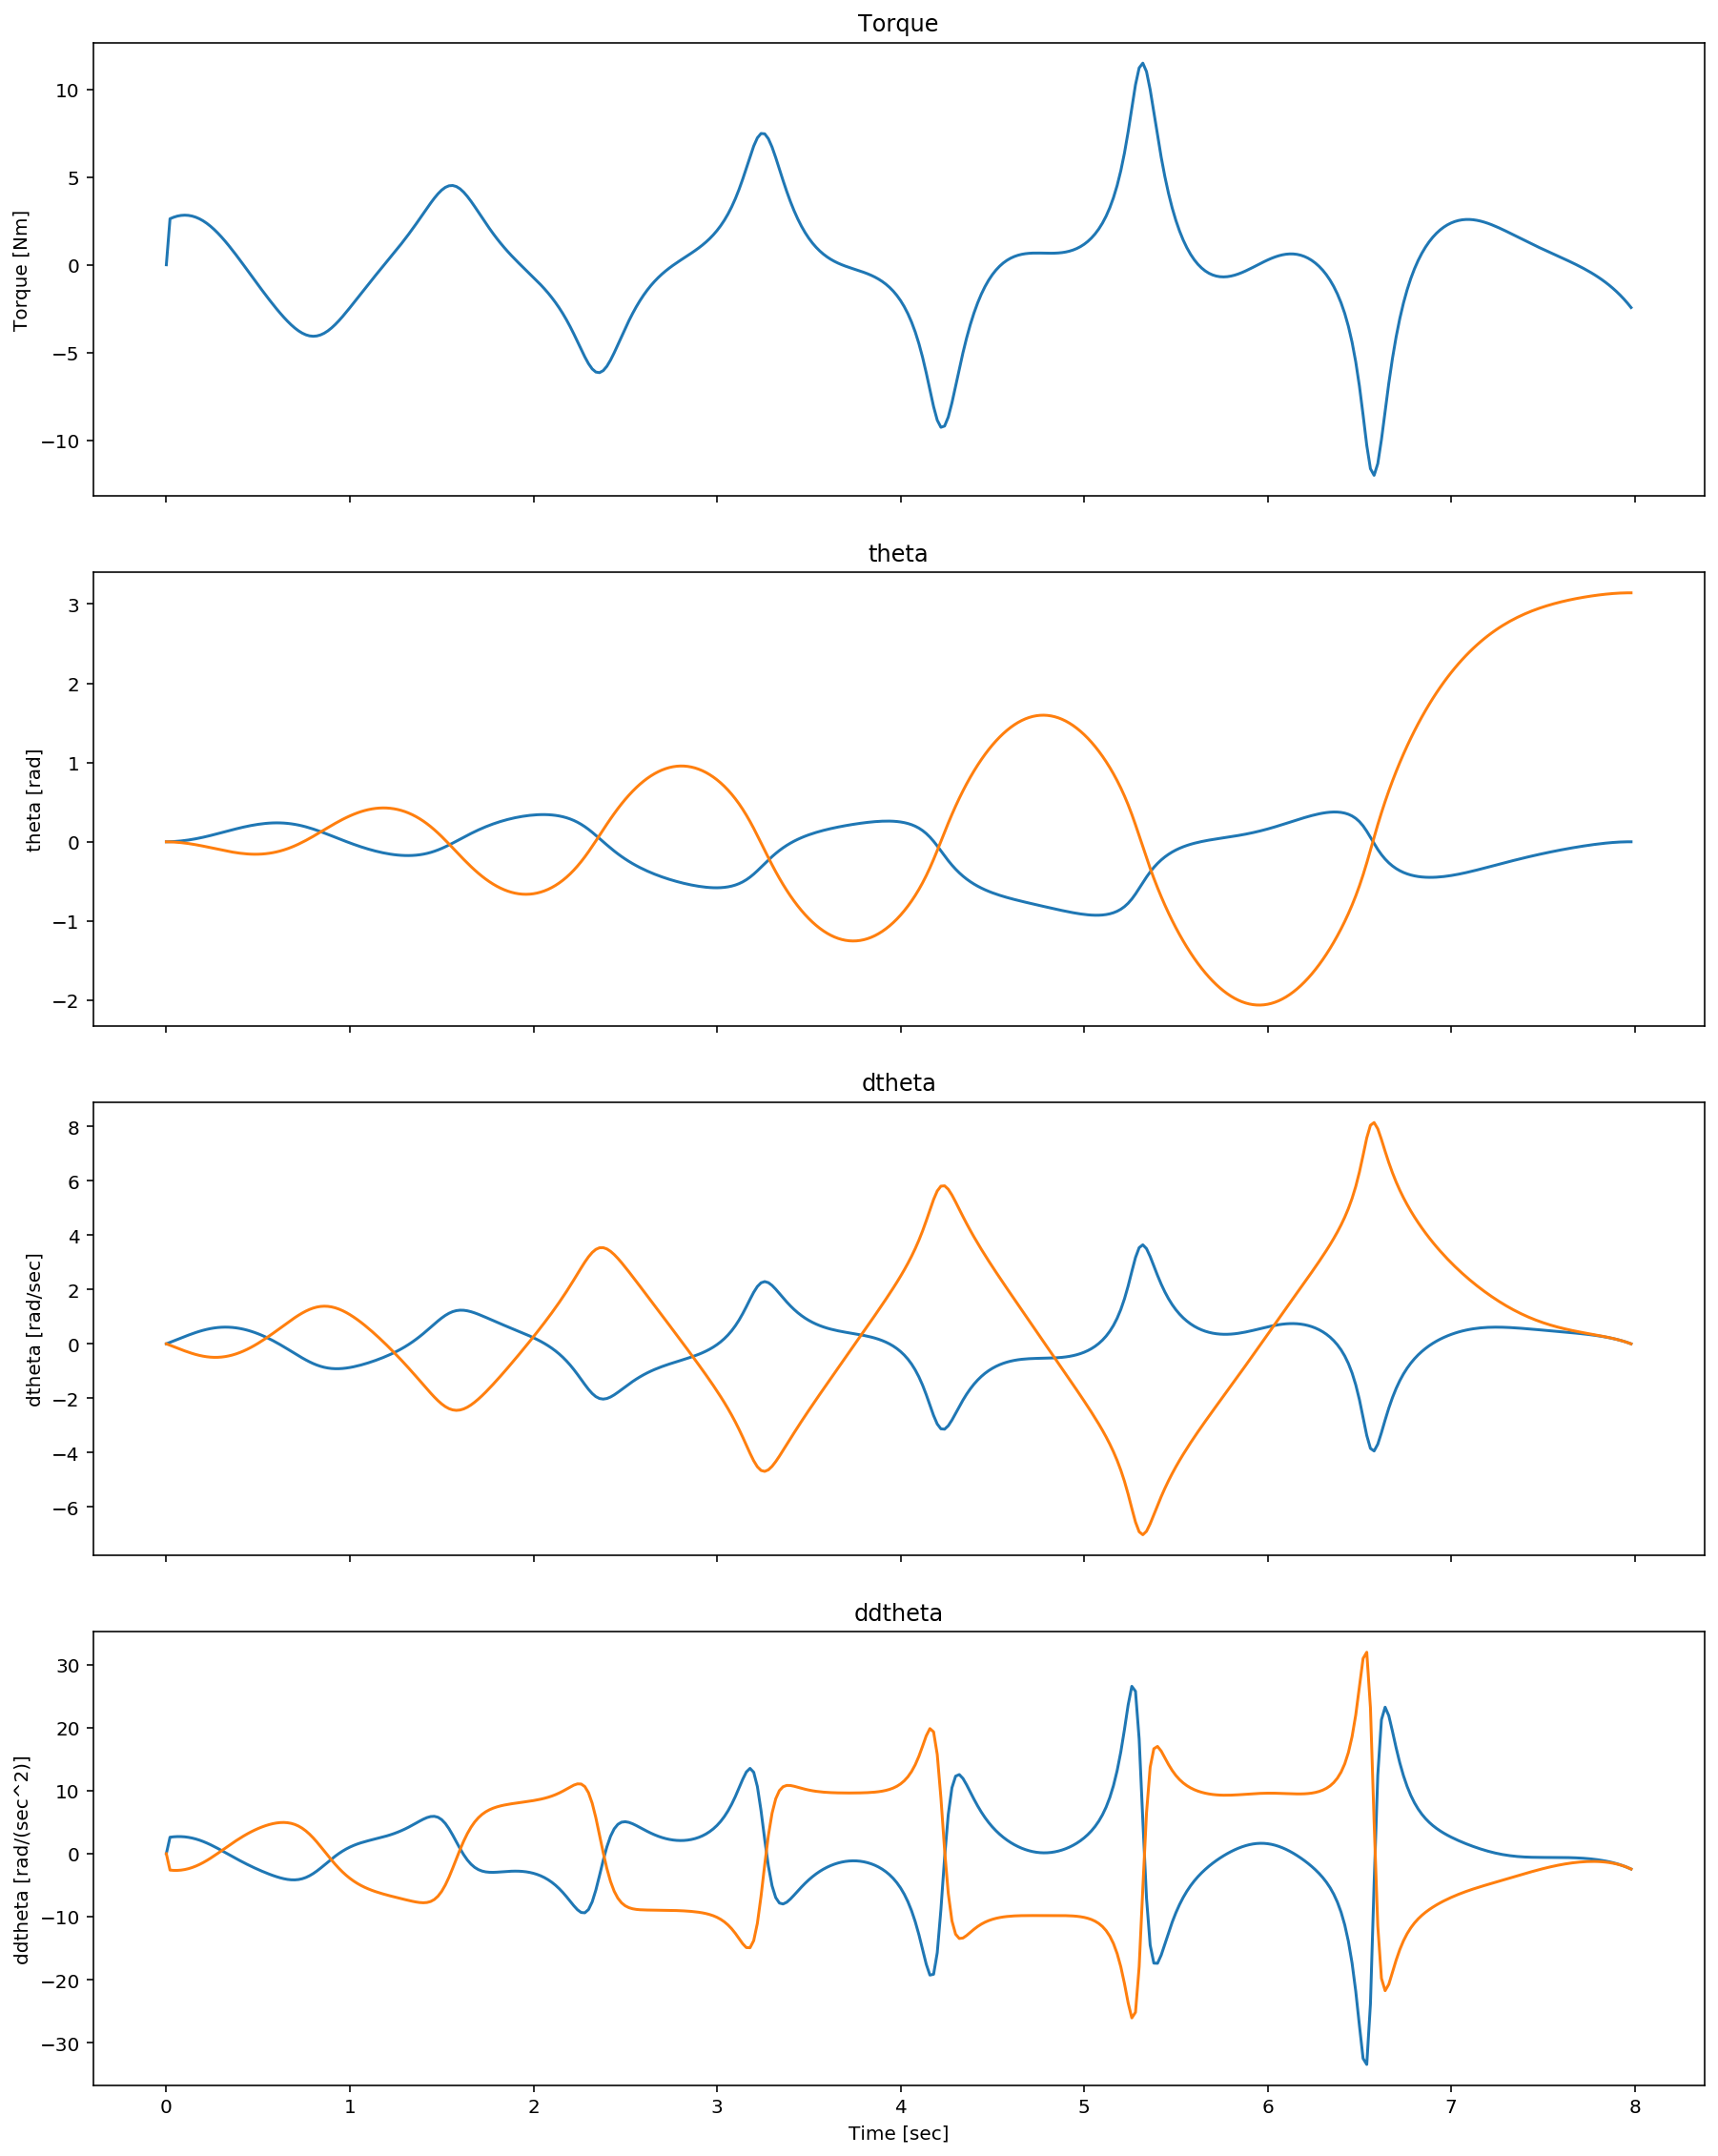

In [16]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(4,1, figsize=(13, 16), sharex=True) #create axes
fig.tight_layout(pad=3.0)
time = [i*m.h for i in range(N)]
plt.xlabel('Time [sec]')
#Torque
torques = [i.value for i in m.Tc.values()]
ax1.plot(time, torques)
ax1.set_ylabel('Torque [Nm]')
ax1.set_title('Torque')
#Pos
for i in range(1,len(m.L)+1):
    theta = [m.th[(j, i)].value for j in range(1, len(m.N)+1)]
    ax2.plot(time, theta)
    ax2.set_ylabel('theta [rad]')
    ax2.set_title('theta')
#Vel
for i in range(1,len(m.L)+1):
    dtheta = [m.dth[(j, i)].value for j in range(1, len(m.N)+1)]
    ax3.plot(time, dtheta)
    ax3.set_ylabel('dtheta [rad/sec]')
    ax3.set_title('dtheta')
#Acc    
for i in range(1,len(m.L)+1):
    ddtheta = [m.ddth[(j, i)].value for j in range(1, len(m.N)+1)]
    ax4.plot(time, ddtheta)
    ax4.set_ylabel('ddtheta [rad/(sec^2)]')
    ax4.set_title('ddtheta')

In [17]:
theta_1 = [m.th[(i, 1)].value for i in range(1, N+1)]
theta_2 = [m.th[(i, 2)].value for i in range(1, N+1)]
dtheta_1 = [m.dth[(i, 1)].value for i in range(1, N+1)]
dtheta_2 = [m.dth[(i, 2)].value for i in range(1, N+1)]
ddtheta_1 = [m.ddth[(i, 1)].value for i in range(1, N+1)]
ddtheta_2 = [m.ddth[(i, 2)].value for i in range(1, N+1)]
torque = [m.Tc[(i)].value for i in range(1, N+1)]

x0, y0, z0, x1, y1, z1, x2, y2, z2 = [], [], [], [], [], [], [], [], []
for i in range(1, N+1):
    psi1_val = m.th[i, 1].value
    phi2_val = m.th[i, 2].value
    l1_val = m.len[1]
    l2_val = m.len[2]
    x0.append(0)
    y0.append(0)
    z0.append(0)
    x1.append(lamb_x1(psi1_val, phi2_val, l1_val, l2_val))
    y1.append(lamb_y1(psi1_val, phi2_val, l1_val, l2_val))
    z1.append(lamb_z1(psi1_val, phi2_val, l1_val, l2_val))
    x2.append(lamb_x2(psi1_val, phi2_val, l1_val, l2_val))
    y2.append(lamb_y2(psi1_val, phi2_val, l1_val, l2_val))
    z2.append(lamb_z2(psi1_val, phi2_val, l1_val, l2_val))
pts0 = np.vstack([x0,y0,z0]).T.reshape((-1,3))
pts1 = np.vstack([x1,y1,z1]).T.reshape((-1,3))
pts2 = np.vstack([x2,y2,z2]).T.reshape((-1,3))
pts_arr = []
for K, R, t in zip(K_arr, R_arr, t_arr):
    pts0_2d = project(pts0, K, R, t)
    pts1_2d = project(pts1, K, R, t)
    pts2_2d = project(pts2, K, R, t)
    pts_arr.append([pts0_2d, pts1_2d, pts2_2d])
pts_arr= np.array(pts_arr)

#SAVE TO FILE
with open("measurements_3d.pickle", "wb") as f:
    pickle.dump(pts_arr[:,1:].tolist(),f) # n_cam x n_pts x N x 2
with open("cam_params_3d.pickle", "wb") as f:
    pickle.dump([K_arr.tolist(), R_arr.tolist(), t_arr.tolist()],f)
with open("states_3d.pickle", "wb") as f:
    pickle.dump([theta_1, theta_2, dtheta_1, dtheta_2, ddtheta_1, ddtheta_2, torque], f)